In [1]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [2]:
# Adjust paths if needed
TRAIN_DIR = "/kaggle/input/dyselxia/Gambo/Train"
TEST_DIR  = "/kaggle/input/dyselxia/Gambo/Test"


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
original_train_dir = "/kaggle/input/dyselxia/Gambo/Train"
new_train_dir = "/kaggle/working/Train"  # New Train folder
val_dir = "/kaggle/working/Validation"  # New Validation folder

# Set validation split percentage
val_split = 0.30  # 10% for validation, 90% remains in train

# Ensure directories exist
os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Loop through each class and split
for category in os.listdir(original_train_dir):
    category_path = os.path.join(original_train_dir, category)
    if not os.path.isdir(category_path):
        continue  # Skip non-directory files

    # Create class folders in new train and validation directories
    os.makedirs(os.path.join(new_train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

    images = os.listdir(category_path)
    
    # Split train into train (90%) and validation (10%)
    train_images, val_images = train_test_split(images, test_size=val_split, random_state=42)

    # Copy training images to new Train folder
    for img in train_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(new_train_dir, category, img))

    # Copy validation images to Validation folder
    for img in val_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(val_dir, category, img))

    print(f"Copied {len(train_images)} images to /kaggle/working/Train/{category}")
    print(f"Copied {len(val_images)} images to /kaggle/working/Validation/{category}")

print("New Train and Validation sets created successfully.")


Copied 32746 images to /kaggle/working/Train/Reversal
Copied 14035 images to /kaggle/working/Validation/Reversal
Copied 45873 images to /kaggle/working/Train/Corrected
Copied 19661 images to /kaggle/working/Validation/Corrected
Copied 27533 images to /kaggle/working/Train/Normal
Copied 11801 images to /kaggle/working/Validation/Normal
New Train and Validation sets created successfully.


In [4]:
import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image, ImageOps, ImageEnhance

# Define transformation pipeline for LeNet
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize for LeNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

class DyslexiaTrainDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['Normal', 'Reversal', 'Corrected']
        self.image_paths = []
        self.labels = []

        # Precompute class paths to reduce redundant path joining
        class_dirs = {cls: os.path.join(self.root_dir, cls) for cls in self.classes}

        for label, (class_name, class_dir) in enumerate(class_dirs.items()):
            if os.path.exists(class_dir):
                self.image_paths.extend([os.path.join(class_dir, img) for img in os.listdir(class_dir)])
                self.labels.extend([label] * len(os.listdir(class_dir)))
            else:
                print(f"Warning: Directory {class_dir} does not exist.")

    def __len__(self):
        return len(self.image_paths)

    def augment_image(self, image, label):
        """Apply controlled augmentation based on class label"""

        # Random rotation (-25 to +25 degrees)
        image = image.rotate(random.uniform(-20, 20))

        # Random horizontal flip (50% chance)
        if random.random() < 0.5:
            image = ImageOps.mirror(image)

        # Random vertical flip (10% chance)
        if random.random() < 0.1:
            image = ImageOps.flip(image)

        # Random affine transformations (small scaling, translation)
        if random.random() < 0.5:
            affine_transform = transforms.RandomAffine(
                degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)
            )
            image = affine_transform(image)

        # Contrast adjustment (fading or enhancing)
        if random.random() < 0.3:
            contrast_factor = random.uniform(0.7, 1.3)  # Random contrast change
            image = ImageEnhance.Contrast(image).enhance(contrast_factor)

        # Elastic transformation (to simulate handwriting distortions)
        if random.random() < 0.2:
            image = self.elastic_transform(image)

        # Controlled noise addition (only for Reversal & Corrected classes)
        if label in [1, 2]:  # Apply noise only to these classes
            img_array = np.array(image).astype(np.float32) / 255.0
            noise_std = random.uniform(0.02, 0.06) if label == 1 else random.uniform(0.01, 0.04)  
            noise = np.random.normal(0, noise_std, img_array.shape)
            img_array = np.clip(img_array + noise, 0, 1)  # Keep pixel values in [0, 1]
            image = Image.fromarray((img_array * 255).astype(np.uint8))

        return image

    def elastic_transform(self, image, alpha=5, sigma=2):
        """Apply elastic deformation to an image."""
        img_array = np.array(image)
        shape = img_array.shape

        # Generate random displacement fields
        dx = np.random.randn(*shape) * sigma
        dy = np.random.randn(*shape) * sigma
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))

        # Apply displacements
        indices = (
            np.clip(y + dy, 0, shape[0] - 1).astype(np.int32),
            np.clip(x + dx, 0, shape[1] - 1).astype(np.int32),
        )
        distorted_img = img_array[indices]
        return Image.fromarray(distorted_img)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale

        # Apply augmentation to 50% of the images
        if random.random() < 0.5:
            image = self.augment_image(image, label)

        # Resize for LeNet
        image = image.resize((32, 32), Image.Resampling.LANCZOS)

        # Apply final transformations
        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
class DyslexiaValTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['Normal', 'Reversal', 'Corrected']
        self.image_paths = []
        self.labels = []

        # Load image paths and labels
        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.exists(class_dir):  # Check if the directory exists
                for img_name in os.listdir(class_dir):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(idx)
            else:
                print(f"Warning: Directory {class_dir} does not exist.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale

        # Resize to 32x32
        image = image.resize((32, 32), Image.Resampling.LANCZOS)

        # Apply additional transforms (e.g., normalization)
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Create datasets
train_dataset = DyslexiaTrainDataset(root_dir='/kaggle/working/Train', transform=transform)
val_dataset = DyslexiaValTestDataset(root_dir='/kaggle/working/Validation', transform=transform)
test_dataset = DyslexiaValTestDataset(root_dir='/kaggle/input/dyselxia/Gambo/Test', transform=transform)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 106152
Validation set size: 45497
Test set size: 56723


In [7]:
from torch.utils.data import DataLoader

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

Training Samples:


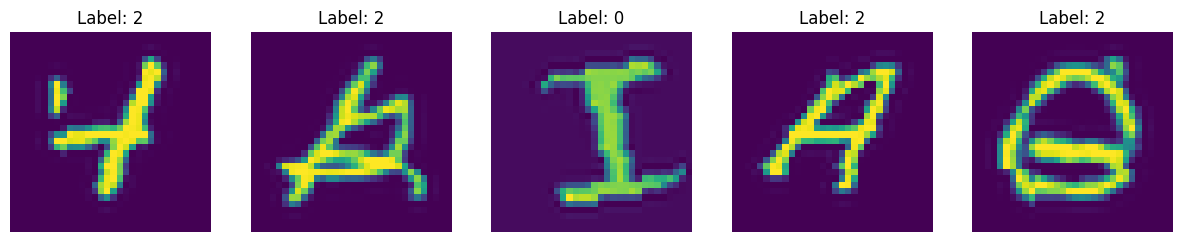

Validation Samples:


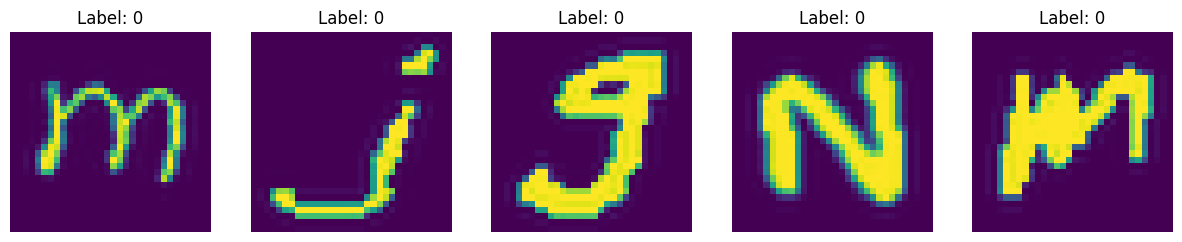

Testing Samples:


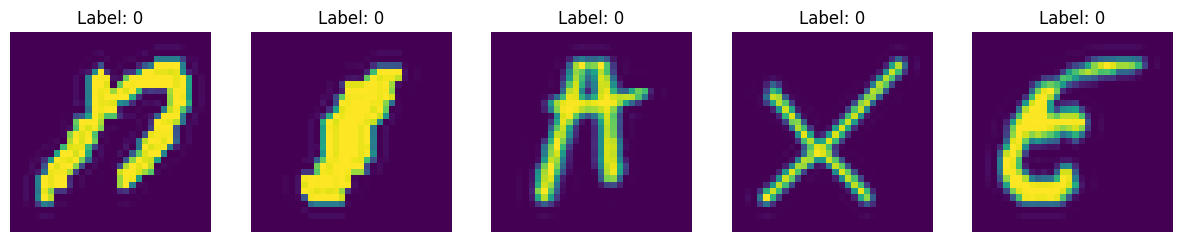

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to visualize images from a DataLoader
def visualize(loader, num_samples=5):
    # Iterate through the DataLoader to get a batch of data
    for batch_idx, (images, labels) in enumerate(loader):
        # Plot the images
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
        for i in range(num_samples):
            ax = axes[i]
            ax.imshow(np.transpose(images[i], (1, 2, 0)))
            ax.set_title(f"Label: {labels[i]}")
            ax.axis('off')
        plt.show()
        break  # Stop after displaying the first batch

# Visualize samples from the training loader
print("Training Samples:")
visualize(train_loader)

# Visualize samples from the validation loader
print("Validation Samples:")
visualize(val_loader)

print("Testing Samples:")
visualize(test_loader)

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler  # Correct mixed precision import

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
class ModifiedLeNet5(nn.Module):
    def __init__(self):
        super(ModifiedLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(120)
        self.dropout = nn.Dropout(0.2)  # Increased dropout
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 3)  # No softmax (CrossEntropyLoss expects logits)

    def forward(self, x):
        x = F.silu(self.bn1(self.conv1(x)))  
        x = self.pool1(x)
        x = F.silu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.silu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.silu(self.fc1(x))
        x = self.fc2(x)  
        return x

# Instantiate model and move to device
model = ModifiedLeNet5().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Enable mixed precision
scaler = GradScaler()

# Training function
def train_with_history(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    history = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": []
    }

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, preds = outputs.max(1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        scheduler.step(avg_val_loss)

        # Log history
        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(val_acc)

        # Print progress
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

# Testing function
def test(model, test_loader):
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    test_acc = test_correct / test_total
    print(f"Test Accuracy: {test_acc:.4f}")

# Train and test
history = train_with_history(model, train_loader, val_loader, criterion, optimizer, epochs=20)
test(model, test_loader)


<ipython-input-23-7356abcbb278>:48: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-23-7356abcbb278>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/20 | Train Loss: 0.4803, Train Acc: 0.7923 | Val Loss: 0.2463, Val Acc: 0.9083
Epoch 2/20 | Train Loss: 0.3563, Train Acc: 0.8476 | Val Loss: 0.1615, Val Acc: 0.9438
Epoch 3/20 | Train Loss: 0.3122, Train Acc: 0.8672 | Val Loss: 0.1340, Val Acc: 0.9524
Epoch 4/20 | Train Loss: 0.2775, Train Acc: 0.8821 | Val Loss: 0.1240, Val Acc: 0.9576
Epoch 5/20 | Train Loss: 0.2576, Train Acc: 0.8932 | Val Loss: 0.1285, Val Acc: 0.9554
Epoch 6/20 | Train Loss: 0.2382, Train Acc: 0.9022 | Val Loss: 0.1280, Val Acc: 0.9539
Epoch 7/20 | Train Loss: 0.2296, Train Acc: 0.9057 | Val Loss: 0.0984, Val Acc: 0.9674
Epoch 8/20 | Train Loss: 0.2190, Train Acc: 0.9099 | Val Loss: 0.0996, Val Acc: 0.9661
Epoch 9/20 | Train Loss: 0.2089, Train Acc: 0.9141 | Val Loss: 0.1090, Val Acc: 0.9623
Epoch 10/20 | Train Loss: 0.2026, Train Acc: 0.9178 | Val Loss: 0.1173, Val Acc: 0.9589
Epoch 11/20 | Train Loss: 0.1960, Train Acc: 0.9206 | Val Loss: 0.1184, Val Acc: 0.9563
Epoch 12/20 | Train Loss: 0.1816, Train A

In [10]:
print(f"Training set size (after augmentation): {len(train_loader)}")
print(f"Validation set size: {len(val_loader)}")
print(f"Test set size: {len(test_loader)}")


Training set size (after augmentation): 3318
Validation set size: 1422
Test set size: 1773


In [24]:
def plot_metrics(history):
    epochs = len(history["train_loss"])
    plt.figure(figsize=(14,5))

    # Loss plot
    plt.subplot(1,2,1)
    plt.plot(range(1, epochs+1), history["train_loss"], label="Train Loss")
    plt.plot(range(1, epochs+1), history["val_loss"], label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1,2,2)
    plt.plot(range(1, epochs+1), history["train_acc"], label="Train Accuracy")
    plt.plot(range(1, epochs+1), history["val_acc"], label="Validation Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()
    

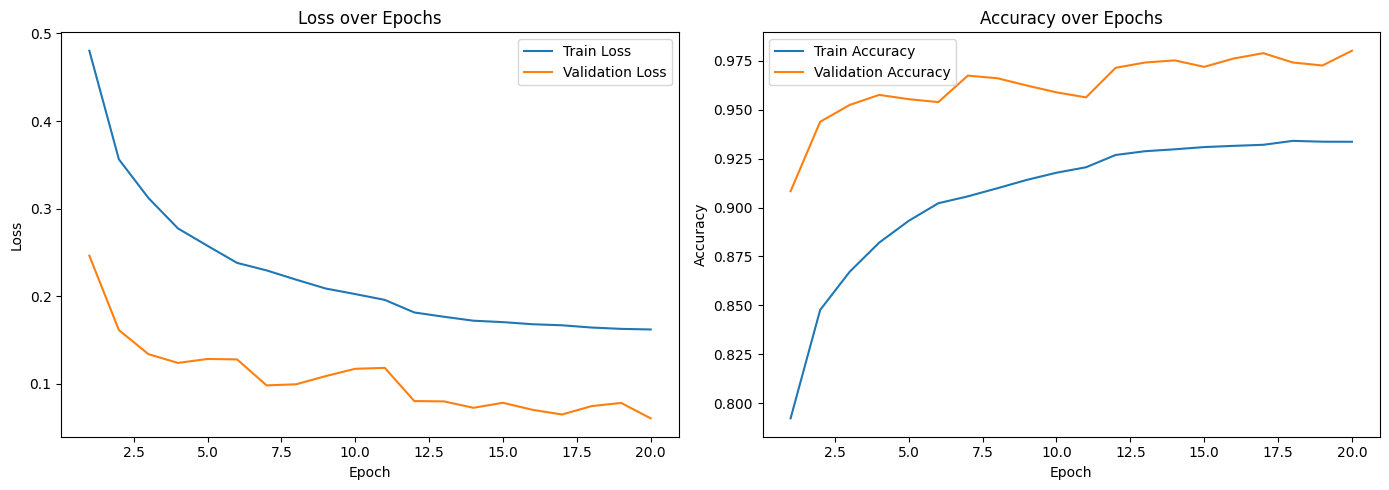

In [25]:
plot_metrics(history)


In [26]:
def test_with_confusion(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute test accuracy
    test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Accuracy: {test_acc:.4f}")

    return all_labels, all_preds


In [29]:
final_train_acc = history['train_acc'][-1] * 100
final_val_acc = history['val_acc'][-1] * 100

print(f"\n✅ Final Training Accuracy: {final_train_acc:.2f}%")
print(f"✅ Final Validation Accuracy: {final_val_acc:.2f}%")


✅ Final Training Accuracy: 93.36%
✅ Final Validation Accuracy: 98.02%


Test Accuracy: 0.8368


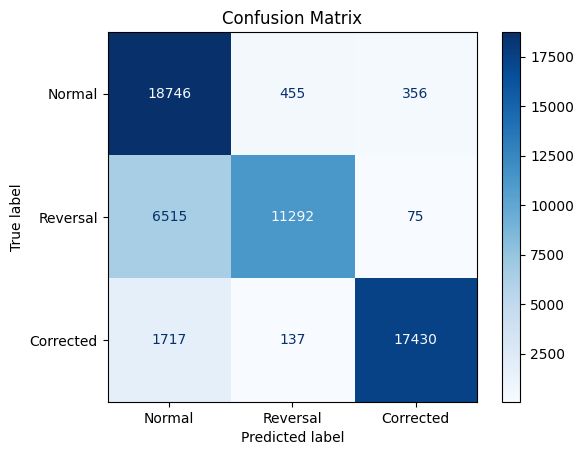

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Call test and collect labels
true_labels, predicted_labels = test_with_confusion(model, test_loader)

# Define your class labels
class_names = ['Normal', 'Reversal', 'Corrected']

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [11]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

def evaluate_model(model, dataloader, device):
    """
    Evaluate the model on a given dataset (e.g., validation or test set).
    Returns:
        - true_labels: Ground truth labels.
        - pred_labels: Predicted labels.
        - accuracy: Overall accuracy.
        - precision: Precision for each class.
        - recall: Recall for each class.
        - f1: F1-score for each class.
        - conf_matrix: Confusion matrix.
    """
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average=None)  # Per-class precision
    recall = recall_score(true_labels, pred_labels, average=None)  # Per-class recall
    f1 = f1_score(true_labels, pred_labels, average=None)  # Per-class F1-score
    conf_matrix = confusion_matrix(true_labels, pred_labels)

    return true_labels, pred_labels, accuracy, precision, recall, f1, conf_matrix

def print_evaluation_metrics(true_labels, pred_labels, accuracy, precision, recall, f1, conf_matrix, class_names):
    """
    Print evaluation metrics in a readable format.
    """
    print(f"Accuracy: {accuracy:.4f}")
    print("\nPer-Class Metrics:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-Score: {f1[i]:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)

def evaluate_on_all_sets(model, train_loader, val_loader, test_loader, device, class_names):
    """
    Evaluate the model on the training, validation, and test sets.
    """
    print("Evaluating on Training Set...")
    train_true, train_pred, train_acc, train_prec, train_rec, train_f1, train_cm = evaluate_model(model, train_loader, device)
    print_evaluation_metrics(train_true, train_pred, train_acc, train_prec, train_rec, train_f1, train_cm, class_names)

    print("\nEvaluating on Validation Set...")
    val_true, val_pred, val_acc, val_prec, val_rec, val_f1, val_cm = evaluate_model(model, val_loader, device)
    print_evaluation_metrics(val_true, val_pred, val_acc, val_prec, val_rec, val_f1, val_cm, class_names)

    print("\nEvaluating on Test Set...")
    test_true, test_pred, test_acc, test_prec, test_rec, test_f1, test_cm = evaluate_model(model, test_loader, device)
    print_evaluation_metrics(test_true, test_pred, test_acc, test_prec, test_rec, test_f1, test_cm, class_names)